# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [85]:
import sys
sys.path.append('../')
from abel import *
import numpy as np
import time


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define the linac and beams

In [96]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######

# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 11 # [m]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.radiation_reaction = True
stage.save_evolution = True

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.radiation_reaction = stage.radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
#source.num_particles = 1000
source.jitter.t = driver.jitter.t
"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1

### Run simulations

In [97]:
start = time.time()
linac.run('linac_example_new_solver', num_shots=1, overwrite=True, parallel=False);
end = time.time()

print((end - start)/60, ' min') # time in minutes

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 1.0% rms, 159.0/0.6 µm-rad)
Number of cores: 5
time =  7.5025458335876465  sec
Tracking element 2 (StageQuasistatic2d, stage 1, s = 5.5 m, 20.9 GeV, -1.60 nC, 3.1% rms, 158.6/0.6 µm-rad)
0.1748877803484599  min


### Plot the wakefield

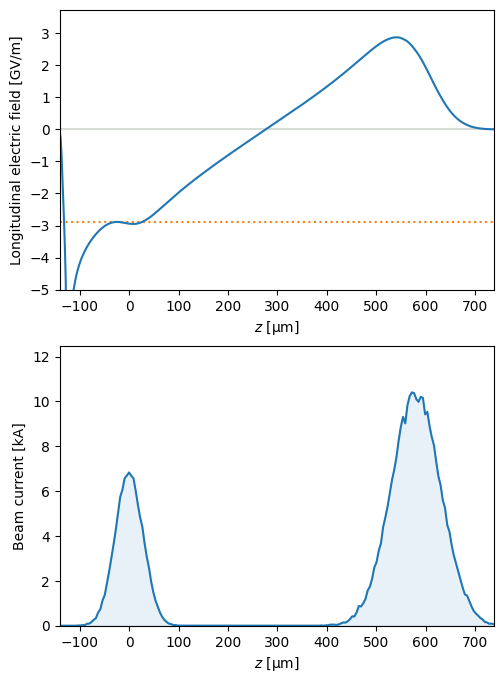

In [15]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

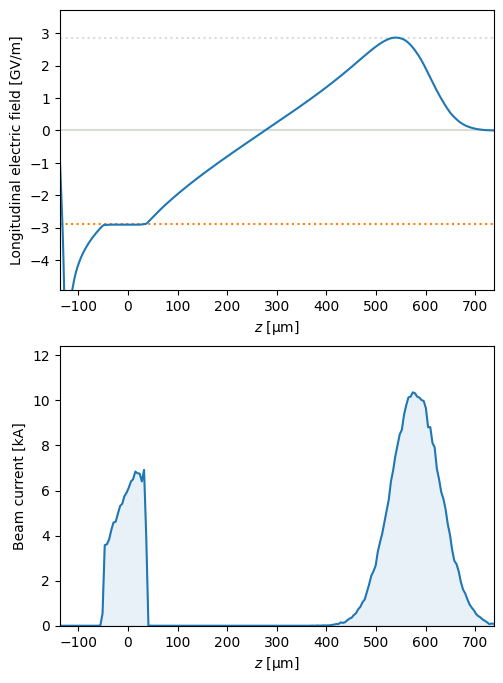

In [16]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

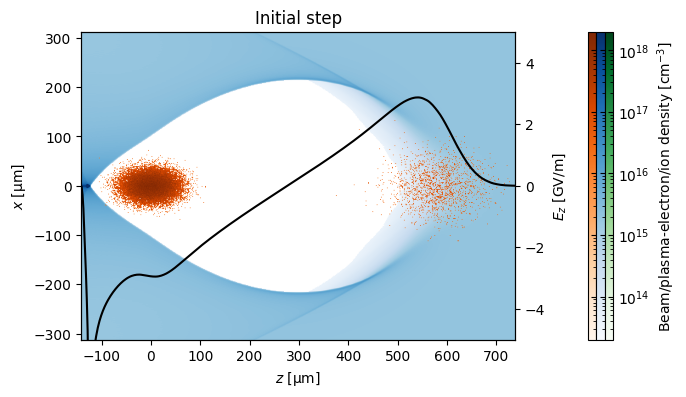

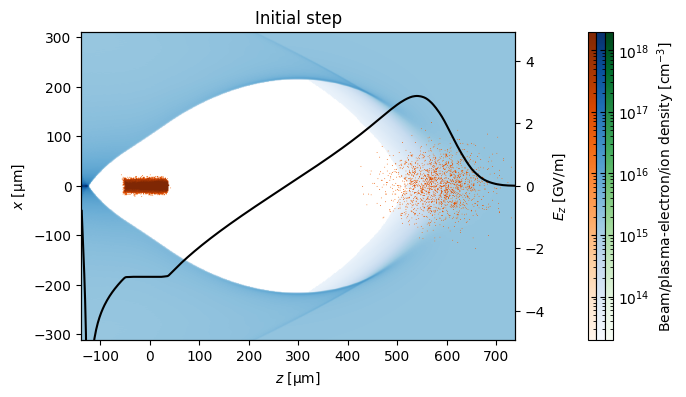

In [17]:
linac.stages[0].plot_wake()
linac.stages[-1].plot_wake()

### Plot beam evolution and survey

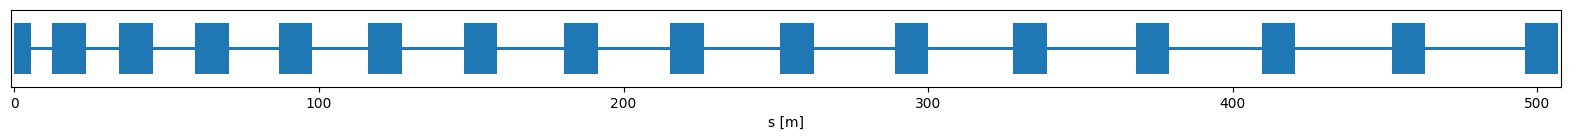

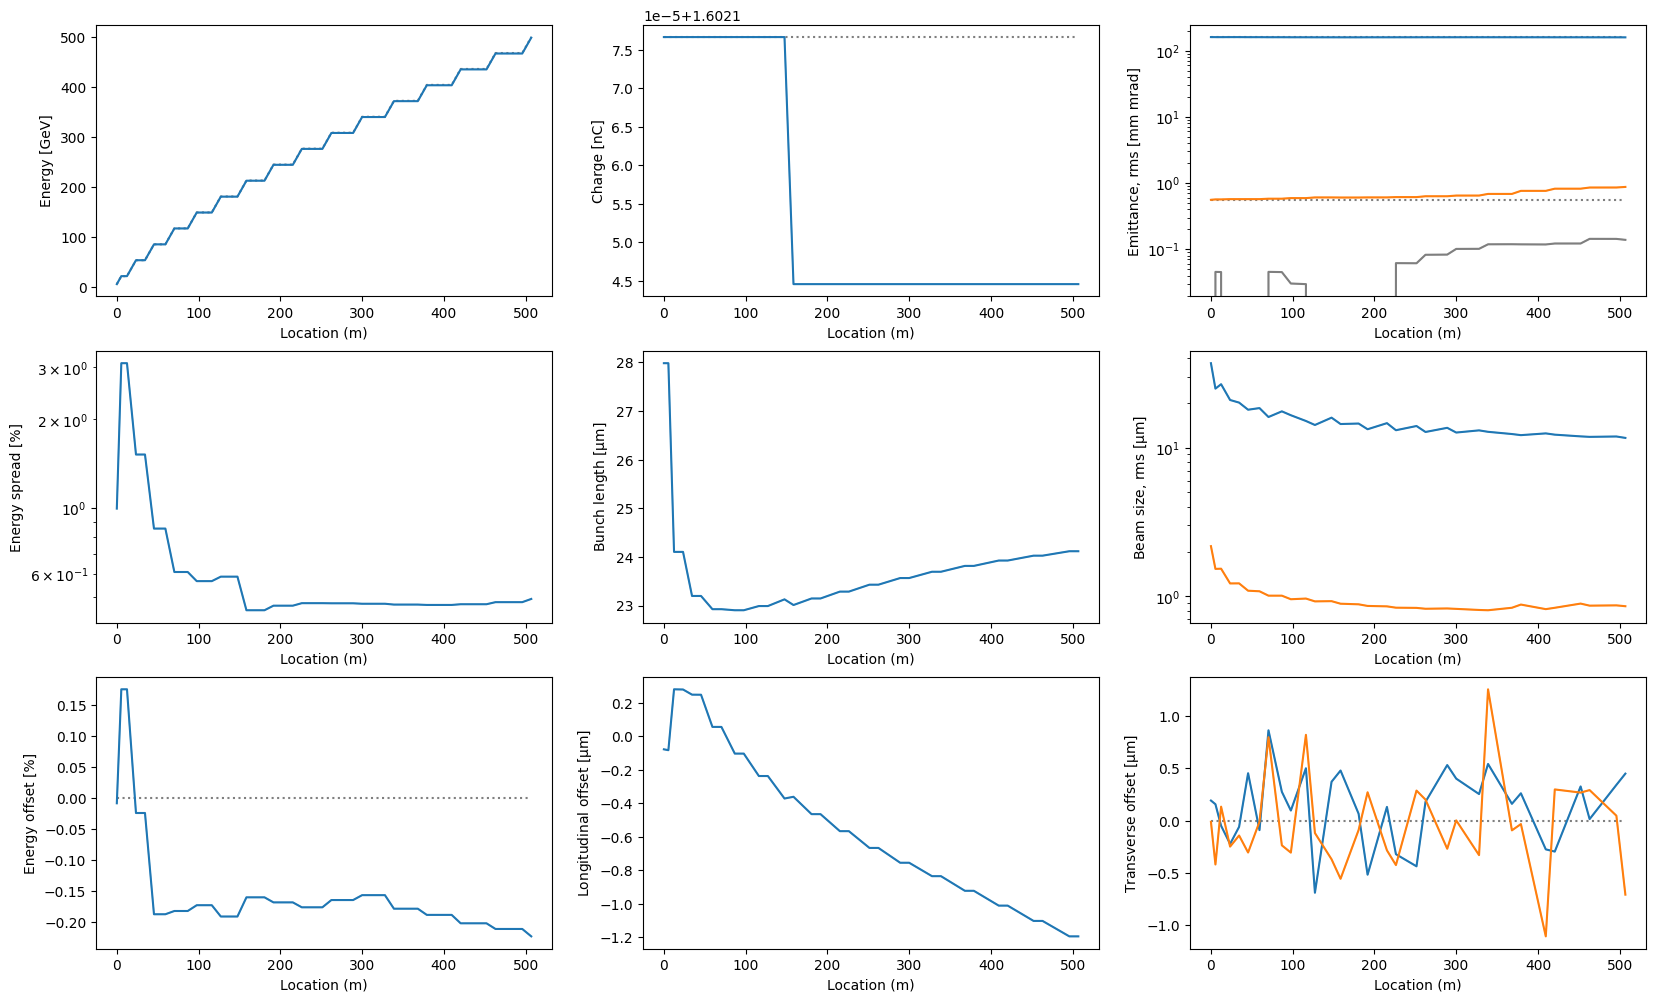

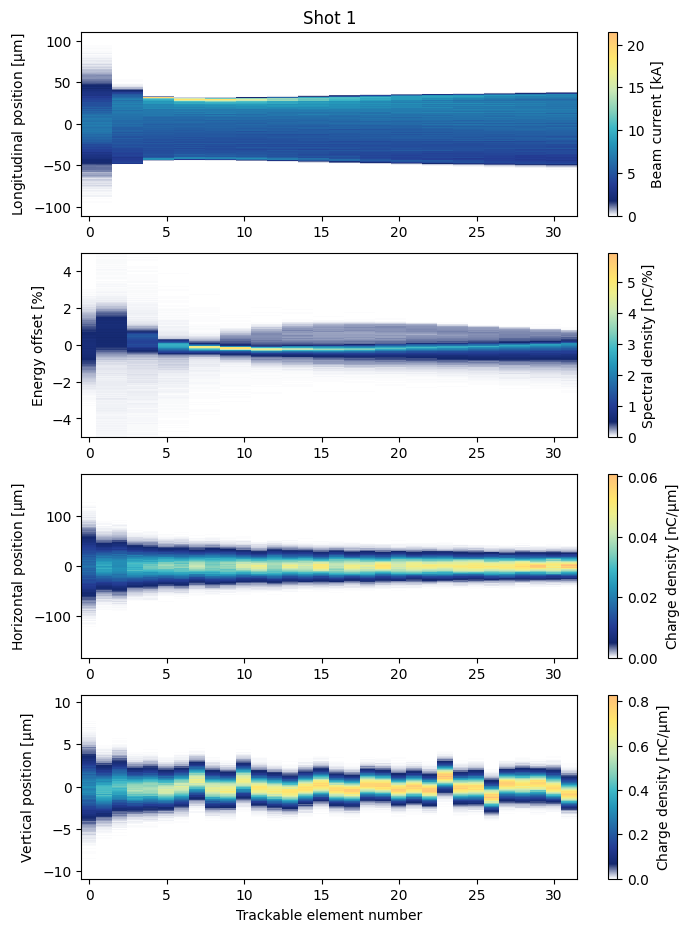

In [18]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False)
linac[0].plot_waterfalls()


In [19]:
linac.animate_lps()

'run_data/linac_example_new_solver/plots/lps_shot0.gif'

![](run_data/linac_example/plots/lps_shot0.gif)

In [49]:
stage_num = 15
shot_num = 0
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [50]:
stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)

AttributeError: 'StageQuasistatic2d' object has no attribute 'print_current_summary'